<h1 style="font-size: 25px; color: blue;">2 - Adding potassium in the medium with a slow ramp</h1>

<br>Contact: guillaumegirier@gmail.com</br>

<br>Commun work: Guillaume Girier, Isa Dallmer-Zerbe, Helmut Schmidt</br>

In this notebook, we investigate the effect of extracellular potassium concentration (Kbath) on the dynamics of the computational model, emphasizing its role in shaping seizure-like activity. Using a simulated protocol of slow potassium addition, we analyze how gradual changes in Kbath influence the model’s behavior. The notebook highlights key features of the model’s response, including the generation of time-series data under varying Kbath conditions and the impact of single-spike stimulations at A=30 mA. Detailed visualizations are provided to illustrate the transition between different dynamical states, offering a mechanistic perspective on how potassium dynamics modulate neuronal excitability and seizure onset. (Corresponding to Fig.2)


<h1 style="font-size: 25px; color: blue;">Library importations :</h1>


In [1]:
#%matplotlib widget
from math import *
from matplotlib.backend_bases import MouseButton
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from scipy.interpolate import interp1d

<h1 style="font-size: 25px; color: blue;">Defining functions :</h1>

<h1 style="font-size: 22px; color: red;"> LFES spike train function :</h1>


In [2]:
def generate_periodic_spike_train(total_time, spike_count, dt):
    time = np.arange(0, total_time, dt)
    spike_train = np.zeros_like(time)

    # Calculer les intervalles entre chaque train de spike
    inter_spike_interval = int(1/(dt*Hz))

    # Générer les trains de spikes
    for i in range(spike_count):
        spike_train[i * inter_spike_interval] = 1

    return spike_train

<h1 style="font-size: 22px; color: red;"> Epileptor-2 model function :</h1>


In [11]:
# Epileptor-2 parameter values

gamma=10.0
deltaKo=0.02
deltaNai=0.03
Ko0=3.0
Nai0=10.0

factor = 1.75
tauK=10.0*factor
tauNa=20.0*factor
rho=0.2/factor
taum=0.002  
taux=2.0
deltax=0.01

G_syn=0.3
vmax= 55.0

Vth=12.4

gle=1.0
gKe=0.5

##############################

# Noise activation : 0/1

sigma=3*np.sqrt(0.001)


##############################

# Connection with the inactive population

I0 = 0
Vsyn = -15
Ssyn = 1
gsyn = 0.1686

eps = 1

##############################

# Setting the stimulation time

Hz = 1
A = 30
stim_size = 2500
space = 59
ini_1 = 4800
ini_2 = ini_1 + stim_size

##############################

# Define auxiliary functions

def         vi(V): return vmax*1./(1+np.exp(Vth-V))
def    ue(V,xD,Ko): return gKe*26.6*np.log(Ko/Ko0)+G_syn*vi(V)*xD+ sigma * np.random.normal(0, 1) 
def Ipump(Ko,Nai): return rho/((1+np.exp(3.5-Ko))*(1+np.exp((25.0-Nai)/3)))

##############################

# Main function

def my_epileptor_2(t_eval, dt, ini):
    
       
    Ve  = np.zeros(len(t_eval))
    xDe = np.zeros(len(t_eval))
    Koe = np.zeros(len(t_eval))
    Naie= np.zeros(len(t_eval))
    Kbath= np.zeros(len(t_eval))
    
    I  = np.zeros(len(t_eval))
    
    Ve[0]  =ini[0]
    xDe[0] =ini[1]
    Koe[0] =ini[2]
    Naie[0]=ini[3]
    Kbath[0]= ini[4]
    
    for i in range(1, len(t_eval)):
        

        liste1 = np.arange(1100000, 1105000, 200)
        liste2 = np.arange(3000000, 3005000, 200)
        liste3 = np.arange(7500000, 7505000, 200)
        liste4 = np.arange(10000000, 10005000, 200)
        if i in liste1  :
            I[i] = 20 
        if i in liste2  :
            I[i] = 20 
        if i in liste3 :
            I[i] = 20 
        if i in liste4  :
            I[i] = 20 
        
        Isyne = gsyn * Ssyn * (Vsyn - Ve[i-1])
    
        Ve[i]  = Ve[i-1] + dt *( (ue(Ve[i-1],xDe[i-1],Koe[i-1])-gle*Ve[i-1]+ Isyne +I[i-1])/taum  )
        xDe[i] = xDe[i-1] + dt *( (1-xDe[i-1])/taux-deltax*xDe[i-1]*vi(Ve[i-1]) )
        Koe[i] = Koe[i-1] + dt * eps * ( (Kbath[i-1]-Koe[i-1])/tauK-2*gamma*Ipump(Koe[i-1],Naie[i-1])+deltaKo*vi(Ve[i-1]))
        Naie[i]= Naie[i-1] + dt * eps * ( (Nai0-Naie[i-1])/tauNa-3*Ipump(Koe[i-1],Naie[i-1])+deltaNai*vi(Ve[i-1]) )
        if i<3000000 :
            Kbath[i]= ini[4]
        else :
            if Kbath[i-1]<= L:
                Kbath[i]= Kbath[i-1] + dt*eps_ramp
            else:
                Kbath[i] = Kbath[i-1]
                
    return np.array([Ve, xDe, Koe, Naie, Kbath, I])

In [12]:
print(np.arange(1100000, 1102000, 200))

[1100000 1100200 1100400 1100600 1100800 1101000 1101200 1101400 1101600
 1101800]


<h1 style="font-size: 25px; color: blue;">Simulations :</h1>

<h1 style="font-size: 22px; color: red;"> Model without LFES effect simulation :</h1>


In [13]:
L=8                                           # Maximal value to reach with the ramp
eps_ramp=0.0003                               # Speed of the ramp

S0=np.array([25.0, 0.7, 3.0, 5.0, 5])         # Initial conditions : V, xD, Ko, Na, Kbath
t_span = (0, 13600)                           # Time span for simulation
dt=0.001
sigma=0*np.sqrt(0.001)
statut = False                                # Choosing if we apply or not the LFES : True = LFES / False = no LFES
t_eval = np.arange(t_span[0], t_span[1], dt)  # Time points to evaluate
sol = my_epileptor_2(t_eval, dt, S0)          # Simulation


<h1 style="font-size: 22px; color: red;"> Saving the time series into variables:</h1>


In [14]:
VVe_ref = sol[0]
XXe_ref = sol[1]
KKe_ref = sol[2]
NNae_ref = sol[3]
Kbath_ref = sol[4]
I_ref = sol[5]
T_ref = t_eval

<h1 style="font-size: 25px; color: blue;">Plotting the results :</h1>

<h1 style="font-size: 22px; color: red;"> Membrane potential time series during the protocol:</h1>


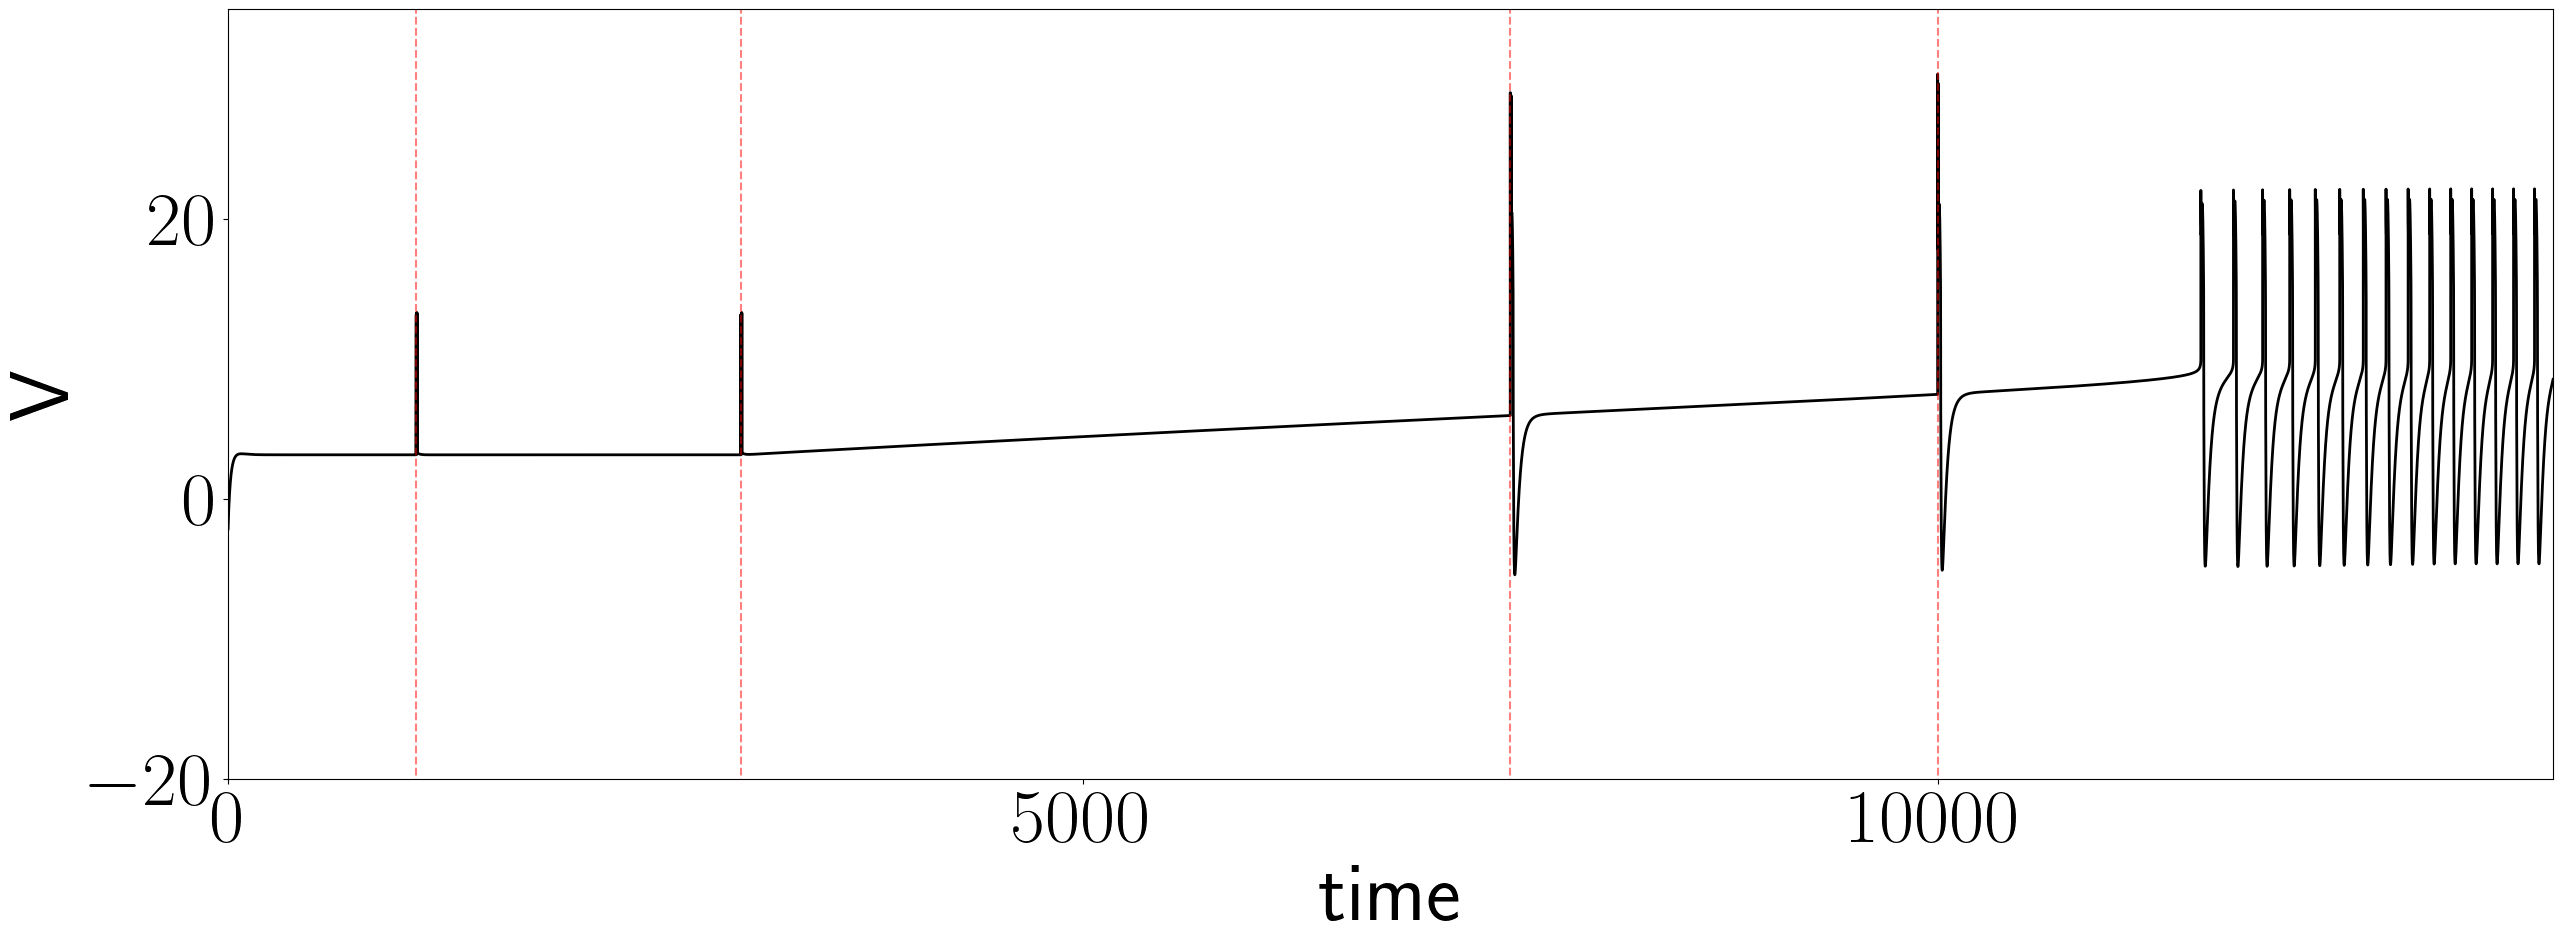

In [15]:
%matplotlib inline

fig = plt.figure(figsize=(30,10)) 
ax = fig.gca()

plt.plot(t_eval[100:], VVe_ref[100:], c='k', alpha = 1, linewidth = 2)

plt.plot(np.ones(10)*1100, np.linspace(-30,40,10), "r--", alpha = 0.5)
plt.plot(np.ones(10)*3000, np.linspace(-30,40,10), "r--", alpha = 0.5)
plt.plot(np.ones(10)*7500, np.linspace(-30,40,10), "r--", alpha = 0.5)
plt.plot(np.ones(10)*10000, np.linspace(-30,40,10), "r--", alpha = 0.5)


#plt.plot(KK1[10000:25000], VV1[10000:25000], "k", alpha = 1, linewidth = 2, label = "Reference signal")



plt.rc('text', usetex=True)

plt.xlim([0, 13600])
plt.ylim([-20,35])
plt.locator_params(axis="x", nbins=4)
plt.locator_params(axis="y", nbins=4)
ax.tick_params(axis='x', labelsize=55)
ax.tick_params(axis='y', labelsize=55)
xLabel = ax.set_xlabel('time', linespacing=3, fontsize=60)
yLabel = ax.set_ylabel('V',  rotation=90, linespacing=3, fontsize=60)
ax.dist = 10

plt.savefig("New_Fig_original_param_V.svg", format='svg')

#plt.legend(prop={'size': 35})
#plt.title("Morris-Lecar bifurcation diagram")
plt.show()




<h1 style="font-size: 22px; color: red;"> From the experimental data, producing the Kbath time series in time :</h1>


In [16]:
mM  = [5,    6,  6.5,    7, 7.25,   7.5,  7.75,     8]
tmM = [0, 3600, 5400, 8100, 9600, 10680, 11700, 12600]

mM_timeseries = np.zeros(12600)
tmM_timeseries = np.arange(0,12600, 1)

counter = 1
for t in range(len(mM_timeseries)):
    if t<tmM[counter]:
        mM_timeseries[t] = mM[counter-1] 
    if t>=tmM[counter]:
        counter += 1
        mM_timeseries[t] = mM[counter-1] 

mM_timeseries = np.hstack((mM_timeseries, np.ones(1000)*8))
tmM_timeseries = np.hstack((tmM_timeseries, np.arange(12601, 13601, 1)))

<h1 style="font-size: 22px; color: red;"> Overlay of the Kbath concentration from experimental data and model :</h1>


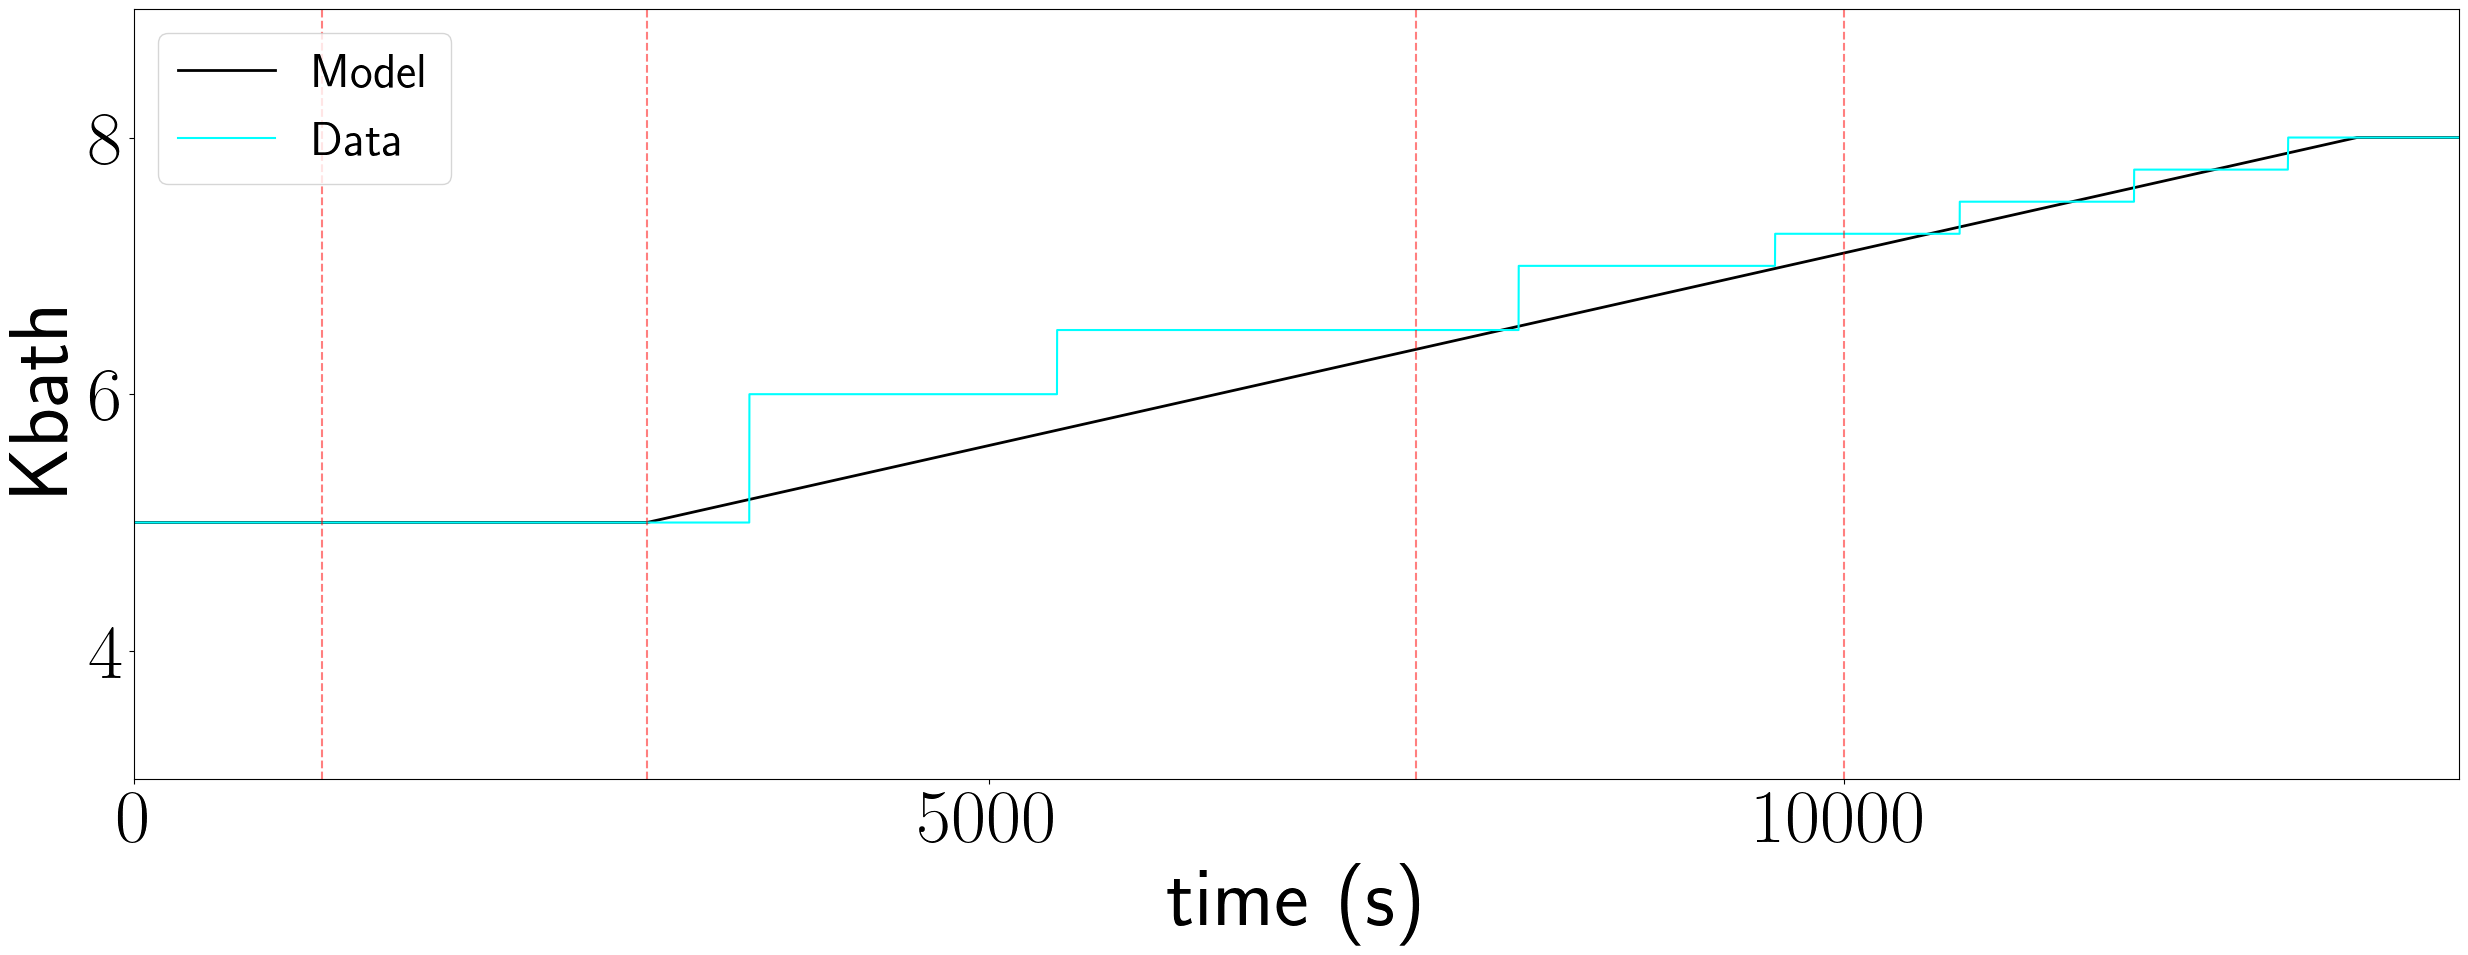

In [17]:
fig = plt.figure(figsize=(30,10)) 
ax = fig.gca()

plt.plot(t_eval[100:], Kbath_ref[100:], c='k', alpha = 1, linewidth = 2, label="Model")

plt.plot(tmM_timeseries, mM_timeseries, c="cyan", label="Data")

plt.plot(np.ones(10)*1100, np.linspace(0,10,10), "r--", alpha = 0.5)
plt.plot(np.ones(10)*3000, np.linspace(0,10,10), "r--", alpha = 0.5)
plt.plot(np.ones(10)*7500, np.linspace(0,10,10), "r--", alpha = 0.5)
plt.plot(np.ones(10)*10000, np.linspace(0,10,10), "r--", alpha = 0.5)


plt.rc('text', usetex=True)

plt.xlim([0, 13600])
plt.ylim([3,9])
plt.locator_params(axis="x", nbins=4)
plt.locator_params(axis="y", nbins=4)
ax.tick_params(axis='x', labelsize=55)
ax.tick_params(axis='y', labelsize=55)
xLabel = ax.set_xlabel('time (s)', linespacing=3, fontsize=60)
yLabel = ax.set_ylabel('Kbath',  rotation=90, linespacing=3, fontsize=60)
ax.dist = 10

plt.savefig("New_Fig_data_param_Kbath.svg", format='svg')

plt.legend(prop={'size': 35}, loc="upper left")
#plt.title("Morris-Lecar bifurcation diagram")
plt.savefig("New_Fig_data_param_Kbath.svg", format='svg')

plt.show()

<h1 style="font-size: 22px; color: red;"> Zoom membrane potential time series during single spike stimulation:</h1>


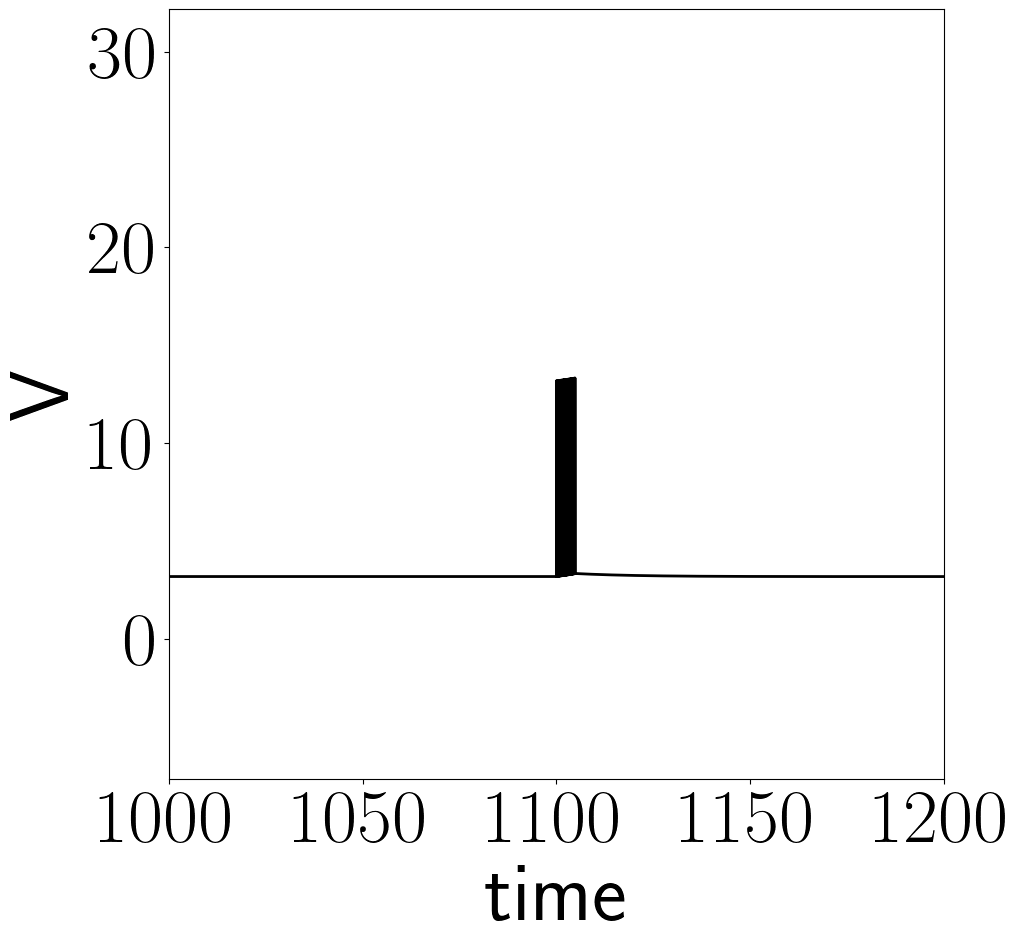

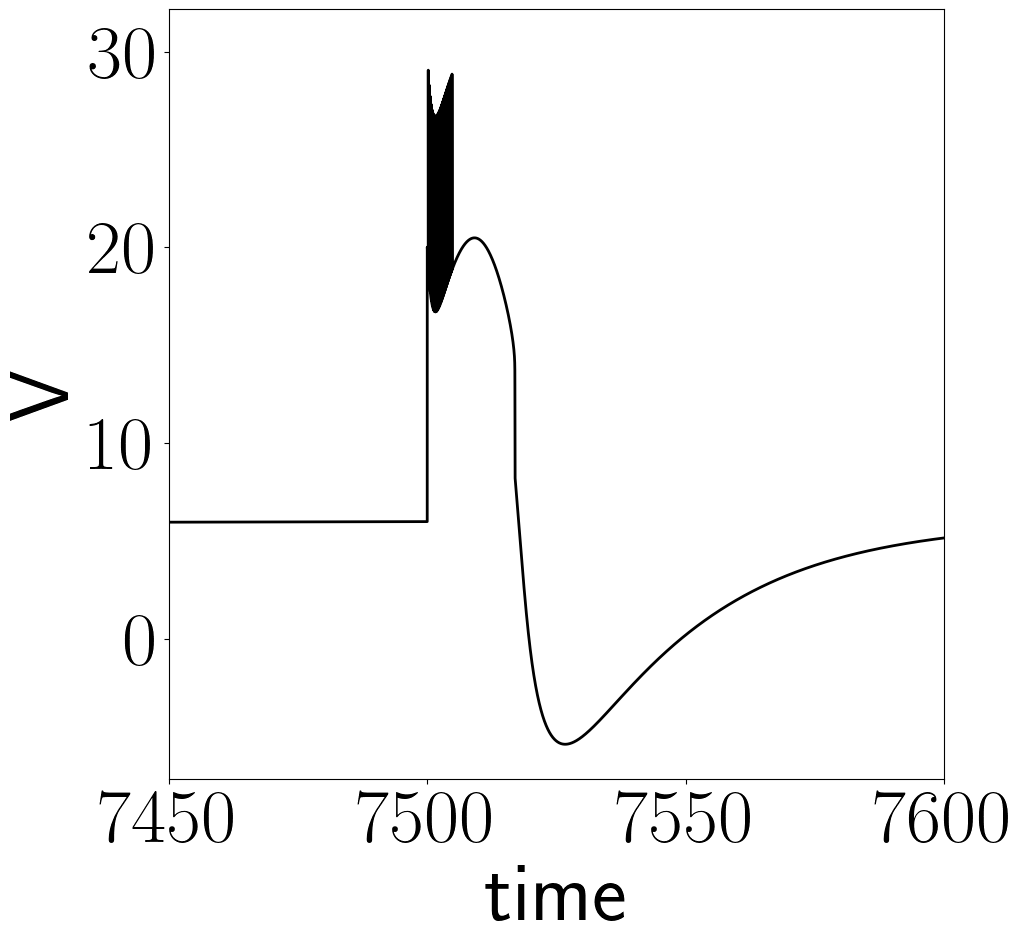

In [18]:
%matplotlib inline

fig = plt.figure(figsize=(10,10)) 
ax = fig.gca()

plt.plot(t_eval[100:], VVe_ref[100:], c='k', alpha = 1, linewidth = 2)


#plt.plot(KK1[10000:25000], VV1[10000:25000], "k", alpha = 1, linewidth = 2, label = "Reference signal")



plt.rc('text', usetex=True)

plt.xlim([1000, 1200])
#plt.ylim([-20,35])
plt.locator_params(axis="x", nbins=4)
plt.locator_params(axis="y", nbins=4)
ax.tick_params(axis='x', labelsize=55)
ax.tick_params(axis='y', labelsize=55)
xLabel = ax.set_xlabel('time', linespacing=3, fontsize=60)
yLabel = ax.set_ylabel('V',  rotation=90, linespacing=3, fontsize=60)
ax.dist = 10

plt.savefig("New_Fig_original_param_zoom_1.svg", format='svg')

#plt.legend(prop={'size': 35})
#plt.title("Morris-Lecar bifurcation diagram")
plt.show()

%matplotlib inline

fig = plt.figure(figsize=(10,10)) 
ax = fig.gca()

plt.plot(t_eval[100:], VVe_ref[100:], c='k', alpha = 1, linewidth = 2)


#plt.plot(KK1[10000:25000], VV1[10000:25000], "k", alpha = 1, linewidth = 2, label = "Reference signal")



plt.rc('text', usetex=True)

plt.xlim([7450, 7600])
#plt.ylim([-20,35])
plt.locator_params(axis="x", nbins=4)
plt.locator_params(axis="y", nbins=4)
ax.tick_params(axis='x', labelsize=55)
ax.tick_params(axis='y', labelsize=55)
xLabel = ax.set_xlabel('time', linespacing=3, fontsize=60)
yLabel = ax.set_ylabel('V',  rotation=90, linespacing=3, fontsize=60)
ax.dist = 10

plt.savefig("New_Fig_original_param_zoom_2.svg", format='svg')

#plt.legend(prop={'size': 35})
#plt.title("Morris-Lecar bifurcation diagram")
plt.show()




